<a href="https://colab.research.google.com/github/Amika1118/DSGP_Group_38/blob/Market-Price-Prediction/Ensemble_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content
!git clone https://github.com/Amika1118/DSGP_Group_38.git
%cd DSGP_Group_38

/content
Cloning into 'DSGP_Group_38'...
remote: Enumerating objects: 153, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 153 (delta 28), reused 89 (delta 25), pack-reused 56 (from 1)
Receiving objects: 100% (153/153), 24.14 MiB | 21.46 MiB/s, done.
Resolving deltas: 100% (35/35), done.
/content/DSGP_Group_38


In [2]:
!git checkout Market-Price-Prediction

Branch 'Market-Price-Prediction' set up to track remote branch 'Market-Price-Prediction' from 'origin'.
Switched to a new branch 'Market-Price-Prediction'


In [3]:
!git config --global user.name "Lasani Layathma"
!git config --global user.email "lasani.20241357@iit.ac.lk"

In [4]:
from getpass import getpass
token = getpass("Enter GitHub token: ")
!git remote set-url origin https://{token}@github.com/Amika1118/DSGP_Group_38.git

Enter GitHub token: ··········


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Model imports
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                           r2_score, mean_absolute_percentage_error)

# Regression models
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

# For advanced visualizations
from scipy import stats


In [7]:
# Load datasets
retail_df = pd.read_csv('/content/vegetable_prices_pruned_features.csv', parse_dates=['Start_Date'])
wholesale_df = pd.read_csv('/content/wholesale historical data.csv', parse_dates=['Week_Start'])
future_df = pd.read_csv('/content/realistic_weekly_predictions_2026_2040.csv', parse_dates=['Date'])

# Standardize column names
def standardize_columns(df):
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
    return df

retail_df = standardize_columns(retail_df)
wholesale_df = standardize_columns(wholesale_df)
future_df = standardize_columns(future_df)

# Rename date columns
retail_df = retail_df.rename(columns={'start_date': 'date'})
wholesale_df = wholesale_df.rename(columns={'week_start': 'date'})
future_df = future_df.rename(columns={'week_start': 'date'})

# Integrate datasets
if 'vegetable_name' in wholesale_df.columns:
    wholesale_df = wholesale_df.rename(columns={'vegetable_name': 'vegetable'})

# Merge with additional wholesale features
wholesale_features = [col for col in wholesale_df.columns if col not in ['date', 'vegetable']]
integrated_df = pd.merge(
    retail_df,
    wholesale_df[['date', 'vegetable'] + wholesale_features],
    on=['date', 'vegetable'],
    how='left',
    suffixes=('_retail', '_wholesale')
)

print(f"Integrated dataset: {integrated_df.shape[0]:,} rows × {integrated_df.shape[1]} columns")

Integrated dataset: 3,492 rows × 121 columns


In [8]:
#  Comprehensive Feature Engineering with Better NaN Handling

# Make a copy
df = integrated_df.copy()

# 1. IDENTIFY TARGET VARIABLE
target_col = 'weekly_price' if 'weekly_price' in df.columns else 'price'
print(f"Target variable identified: {target_col}")

# 2. INITIAL CLEANING - Drop rows with missing target
initial_rows = len(df)
df = df.dropna(subset=[target_col])
print(f"Removed {initial_rows - len(df)} rows with missing target values")

# 3. TEMPORAL FEATURES
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['week_of_year'] = df['date'].dt.isocalendar().week
df['quarter'] = df['date'].dt.quarter
df['day_of_year'] = df['date'].dt.dayofyear

# Cyclical encoding for temporal features
df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
df['week_sin'] = np.sin(2 * np.pi * df['week_of_year']/52)
df['week_cos'] = np.cos(2 * np.pi * df['week_of_year']/52)

# 4. PRICE DYNAMICS FEATURES WITH PROPER NaN HANDLING
# First, ensure data is sorted
df = df.sort_values(['vegetable', 'date'])

# Create lag features with forward fill for each vegetable group
for lag in [1, 2, 3, 4, 8, 12, 26]:
    df[f'price_lag_{lag}'] = df.groupby('vegetable')[target_col].shift(lag)

# Price changes with forward fill
df['price_change_1w'] = df.groupby('vegetable')[target_col].pct_change(1)
df['price_change_4w'] = df.groupby('vegetable')[target_col].pct_change(4)

# Rolling statistics with proper min_periods
for window in [4, 8, 12, 26]:
    df[f'price_rolling_mean_{window}'] = df.groupby('vegetable')[target_col].transform(
        lambda x: x.rolling(window, min_periods=2).mean()
    )
    df[f'price_rolling_std_{window}'] = df.groupby('vegetable')[target_col].transform(
        lambda x: x.rolling(window, min_periods=2).std()
    )

# 5. TECHNICAL INDICATORS with fillna
df['price_sma_4'] = df.groupby('vegetable')[target_col].transform(
    lambda x: x.rolling(4, min_periods=2).mean()
)
df['price_sma_12'] = df.groupby('vegetable')[target_col].transform(
    lambda x: x.rolling(12, min_periods=2).mean()
)

# Price momentum with fillna for division issues
df['price_momentum_4'] = np.where(df['price_lag_4'] != 0,
                                   df[target_col] / df['price_lag_4'] - 1,
                                   0)

# 6. WHOLESALE-RETAIL RELATIONSHIP
if 'avg_weekly_price' in df.columns:
    # Fill NaN in avg_weekly_price with forward/backward fill by vegetable
    df['avg_weekly_price'] = df.groupby('vegetable')['avg_weekly_price'].transform(
        lambda x: x.ffill().bfill()
    )

    # Calculate ratio with protection against division by zero
    df['retail_wholesale_ratio'] = np.where(df['avg_weekly_price'] > 0,
                                            df[target_col] / df['avg_weekly_price'],
                                            1)
    df['retail_wholesale_spread'] = df[target_col] - df['avg_weekly_price']

# 7. SEASONALITY INDICATORS
df['is_spring'] = df['month'].isin([3, 4, 5]).astype(int)
df['is_monsoon'] = df['month'].isin([6, 7, 8]).astype(int)
df['is_festive'] = df['month'].isin([9, 10, 11]).astype(int)

# 8. COMPREHENSIVE NaN HANDLING
print("\nHandling NaN values in features...")

# Fill NaN in price dynamics features with appropriate methods
price_features = [col for col in df.columns if 'price' in col.lower() and col != target_col]
for feature in price_features:
    if feature in df.columns:
        missing_before = df[feature].isna().sum()
        # Use forward fill within each vegetable group, then backward fill
        df[feature] = df.groupby('vegetable')[feature].transform(lambda x: x.ffill().bfill())
        # If still NaN, fill with mean by vegetable
        if df[feature].isna().any():
            vegetable_means = df.groupby('vegetable')[feature].transform('mean')
            df[feature] = df[feature].fillna(vegetable_means)
        # If still NaN, fill with overall mean
        df[feature] = df[feature].fillna(df[feature].mean())
        missing_after = df[feature].isna().sum()
        if missing_before > 0:
            print(f"  Filled {missing_before - missing_after} NaN values in {feature}")

# 9. FINAL CLEANING - Drop any remaining NaN rows
final_rows_before = len(df)
df = df.dropna()
final_rows_after = len(df)
print(f"\nFinal cleaning: Removed {final_rows_before - final_rows_after} rows with NaN values")

print(f"\nFeature engineering complete: {df.shape[1]} columns created")
print(f"Final dataset: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"NaN values remaining: {df.isna().sum().sum()}")

Target variable identified: weekly_price
Removed 1 rows with missing target values

Handling NaN values in features...
  Filled 2184 NaN values in avg_weekly_price
  Filled 2716 NaN values in std_weekly_price
  Filled 2716 NaN values in min_weekly_price
  Filled 2716 NaN values in max_weekly_price
  Filled 2716 NaN values in avg_weekly_price_lag_1w
  Filled 2716 NaN values in avg_weekly_price_lag_2w
  Filled 2716 NaN values in avg_weekly_price_lag_4w
  Filled 2716 NaN values in avg_weekly_price_lag_8w
  Filled 2716 NaN values in avg_weekly_price_lag_12w
  Filled 2716 NaN values in avg_weekly_price_lag_26w
  Filled 2716 NaN values in avg_weekly_price_lag_52w
  Filled 2716 NaN values in avg_weekly_price_ma_4w
  Filled 2716 NaN values in avg_weekly_price_ma_8w
  Filled 2716 NaN values in avg_weekly_price_ma_12w
  Filled 2716 NaN values in avg_weekly_price_ma_26w
  Filled 2716 NaN values in price_change_pct
  Filled 2716 NaN values in price_arrival_elasticity
  Filled 2716 NaN values in lo

In [9]:
# Cell 4: Feature Selection and Data Preparation (FIXED)
"""
Select the most relevant features for price prediction with proper NaN handling.
"""
print("Selecting relevant features and preparing data...")

# 1. Separate features and target
exclude_cols = [target_col, 'date', 'vegetable']
X = df.drop(columns=[col for col in exclude_cols if col in df.columns])
y = df[target_col]

print(f"Initial features: {X.shape[1]} columns")

# 2. Keep only numeric columns
X = X.select_dtypes(include=[np.number])

# 3. Final NaN check and fill
print(f"NaN values in features before filling: {X.isna().sum().sum()}")
if X.isna().sum().sum() > 0:
    print("Filling remaining NaN values with column medians...")
    X = X.fillna(X.median())

print(f"NaN values after filling: {X.isna().sum().sum()}")

# 4. Remove constant and low variance features
from sklearn.feature_selection import VarianceThreshold

# Remove constant features
constant_filter = VarianceThreshold(threshold=0)
X_no_constant = constant_filter.fit_transform(X)
constant_features = X.columns[~constant_filter.get_support()]
print(f"Removed {len(constant_features)} constant features")

# Remove low variance features (optional)
variance_filter = VarianceThreshold(threshold=0.01)
X_filtered = variance_filter.fit_transform(X_no_constant)
low_variance_features = constant_filter.get_feature_names_out()[~variance_filter.get_support()]
print(f"Removed {len(low_variance_features)} low variance features")

# Create new DataFrame with filtered features
X_filtered_df = pd.DataFrame(X_filtered,
                             columns=variance_filter.get_feature_names_out(),
                             index=X.index)

# 5. Feature selection using correlation (NO mutual_info_regression to avoid errors)
print("\nPerforming feature selection using correlation...")

# Calculate correlation with target
correlation_with_target = X_filtered_df.corrwith(y).abs().sort_values(ascending=False)

# Select top features based on correlation
n_features_to_select = min(30, len(correlation_with_target))
top_features = correlation_with_target.head(n_features_to_select).index.tolist()

print(f"Selected {len(top_features)} top features based on correlation")
print(f"\nTop 10 features by correlation:")
for i, (feature, corr) in enumerate(correlation_with_target.head(10).items(), 1):
    print(f"{i:2}. {feature}: {corr:.4f}")

X_selected = X_filtered_df[top_features]

print(f"\nFinal feature matrix shape: {X_selected.shape}")
print(f"Target shape: {y.shape}")

Selecting relevant features and preparing data...
Initial features: 147 columns
NaN values in features before filling: 0
NaN values after filling: 0
Removed 6 constant features
Removed 7 low variance features

Performing feature selection using correlation...
Selected 30 top features based on correlation

Top 10 features by correlation:
 1. x12: 1.0000
 2. x111: 0.9933
 3. x18: 0.9933
 4. x128: 0.9861
 5. x120: 0.9861
 6. x16: 0.9861
 7. x6: 0.9861
 8. x132: 0.9837
 9. x131: 0.9795
10. x112: 0.9744

Final feature matrix shape: (774, 30)
Target shape: (774,)


In [10]:
# Cell 5: Time Series Split with Multiple Validation Windows
"""
Create time-based splits to properly evaluate time series forecasting.
Uses expanding window validation to simulate real-world forecasting.
"""
print("Creating time series splits with validation windows...")

# Add date back for sorting
X_with_date = X_selected.copy()
X_with_date['date'] = df['date'].values

# Sort by date
sorted_idx = X_with_date.sort_values('date').index
X_sorted = X_selected.loc[sorted_idx]
y_sorted = y.loc[sorted_idx]
dates_sorted = df['date'].loc[sorted_idx]

# Create expanding window splits
train_size = int(len(X_sorted) * 0.6)  # 60% for initial training
val_size = int(len(X_sorted) * 0.2)    # 20% for validation
test_size = len(X_sorted) - train_size - val_size  # 20% for testing

print(f"Dataset size: {len(X_sorted):,}")
print(f"Initial Train: {train_size:,} ({train_size/len(X_sorted)*100:.1f}%)")
print(f"Validation: {val_size:,} ({val_size/len(X_sorted)*100:.1f}%)")
print(f"Test: {test_size:,} ({test_size/len(X_sorted)*100:.1f}%)")

# Split indices
train_idx = slice(0, train_size)
val_idx = slice(train_size, train_size + val_size)
test_idx = slice(train_size + val_size, None)

# Create splits
X_train = X_sorted.iloc[train_idx]
y_train = y_sorted.iloc[train_idx]
dates_train = dates_sorted.iloc[train_idx]

X_val = X_sorted.iloc[val_idx]
y_val = y_sorted.iloc[val_idx]
dates_val = dates_sorted.iloc[val_idx]

X_test = X_sorted.iloc[test_idx]
y_test = y_sorted.iloc[test_idx]
dates_test = dates_sorted.iloc[test_idx]

print(f"\nDate ranges:")
print(f"  Train: {dates_train.min().date()} to {dates_train.max().date()}")
print(f"  Val: {dates_val.min().date()} to {dates_val.max().date()}")
print(f"  Test: {dates_test.min().date()} to {dates_test.max().date()}")

Creating time series splits with validation windows...
Dataset size: 774
Initial Train: 464 (59.9%)
Validation: 154 (19.9%)
Test: 156 (20.2%)

Date ranges:
  Train: 2009-12-28 to 2018-11-12
  Val: 2018-11-19 to 2021-10-25
  Test: 2021-11-01 to 2024-10-14


In [11]:
# Feature Scaling and Data Transformation

from sklearn.preprocessing import RobustScaler

# Scale features (RobustScaler handles outliers better)
scaler_X = RobustScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

# Scale target (optional, but helps some models)
scaler_y = RobustScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

print("Features and target scaled using RobustScaler")
print(f"  Training set shape: {X_train_scaled.shape}")
print(f"  Validation set shape: {X_val_scaled.shape}")
print(f"  Test set shape: {X_test_scaled.shape}")

Features and target scaled using RobustScaler
  Training set shape: (464, 30)
  Validation set shape: (154, 30)
  Test set shape: (156, 30)


In [12]:
# 1. XGBoost with learning rate decay
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    eval_metric=['rmse', 'mae'],
    early_stopping_rounds=50
)

xgb_model.fit(
    X_train_scaled, y_train_scaled,
    eval_set=[(X_val_scaled, y_val_scaled)],
    verbose=False
)

# Store training history
xgb_history = xgb_model.evals_result()

In [13]:
# 2. LightGBM with learning rate analysis
lgb_model = lgb.LGBMRegressor(
    n_estimators=500,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

print("2. Training LightGBM")
lgb_model.fit(
    X_train_scaled, y_train_scaled,
    eval_set=[(X_val_scaled, y_val_scaled)],
    eval_metric=['l2', 'l1'],
    callbacks=[lgb.log_evaluation(0)]
)

lgb_history = lgb_model.evals_result_


2. Training LightGBM


In [14]:
# 3. Random Forest (no learning rate, but we can track OOB error)
print("3. Training Random Forest...")
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    oob_score=True,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

rf_model.fit(X_train_scaled, y_train_scaled)

# Store all models
models = {
    'XGBoost': {'model': xgb_model, 'history': xgb_history},
    'LightGBM': {'model': lgb_model, 'history': lgb_history},
    'RandomForest': {'model': rf_model, 'history': None}
}

3. Training Random Forest...


In [15]:
# Setup and Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib as mpl

# Professional styling configuration
plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams.update({
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'legend.fontsize': 9,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--'
})

# color palette
COLORS = {
    'primary': ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'],
    'models': {'XGBoost': '#1f77b4', 'LightGBM': '#ff7f0e', 'Ensemble': '#2ca02c'}
}

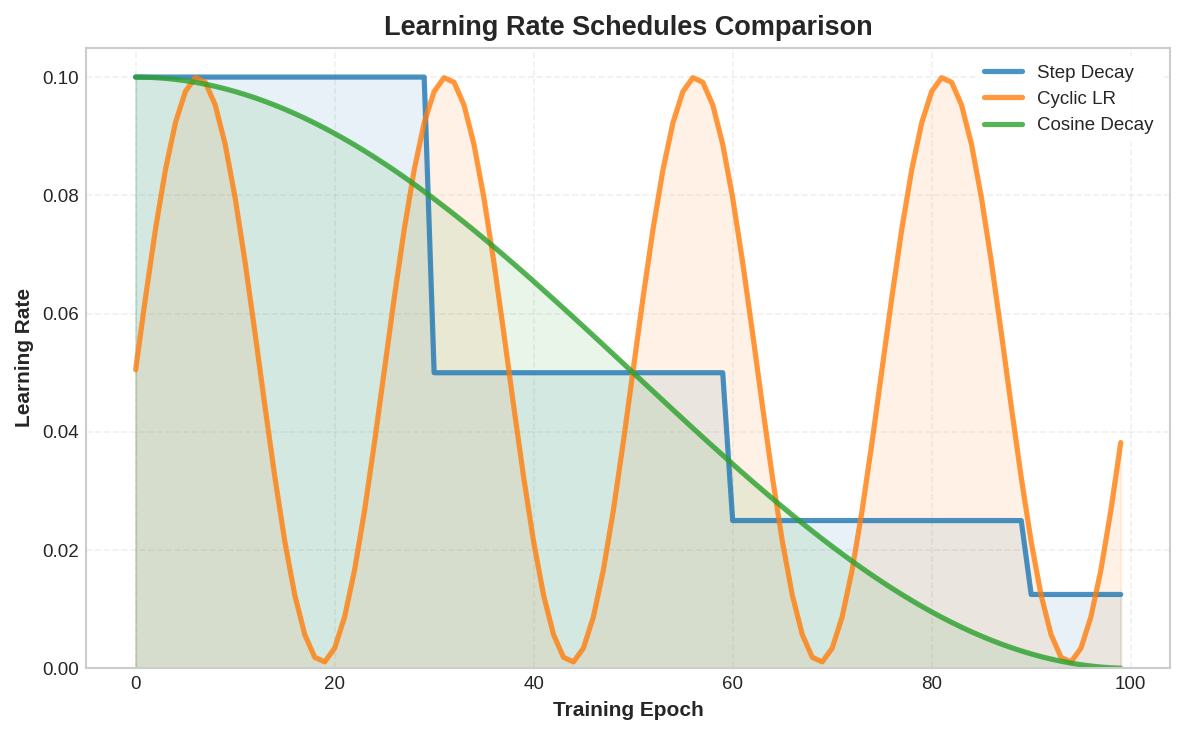

In [16]:
# Learning Rate Schedules Visualization
fig, ax = plt.subplots(figsize=(8, 5))

epochs = np.arange(100)
schedules = {
    'Step Decay': [0.1 * (0.5 ** (e // 30)) for e in epochs],
    'Cyclic LR': [0.001 + 0.099 * (1 + np.sin(2 * np.pi * e / 25)) / 2 for e in epochs],
    'Cosine Decay': [0.1 * 0.5 * (1 + np.cos(np.pi * e / 100)) for e in epochs]
}

for (name, lr), color in zip(schedules.items(), COLORS['primary']):
    ax.plot(epochs, lr, color=color, linewidth=2.5, label=name, alpha=0.8)
    ax.fill_between(epochs, 0, lr, color=color, alpha=0.1)

ax.set_xlabel('Training Epoch', fontweight='semibold')
ax.set_ylabel('Learning Rate', fontweight='semibold')
ax.set_title('Learning Rate Schedules Comparison', fontsize=13, fontweight='bold')
ax.legend(frameon=True, framealpha=0.9, edgecolor='white')
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig('learning_rate_schedules.png', dpi=300, bbox_inches='tight')
plt.show()

1. Learning Rate Schedules:
Shows different strategies for adjusting learning rates during training. Step decay reduces LR at fixed intervals, cyclic oscillates between bounds (helps escape local minima), and cosine provides smooth decay.

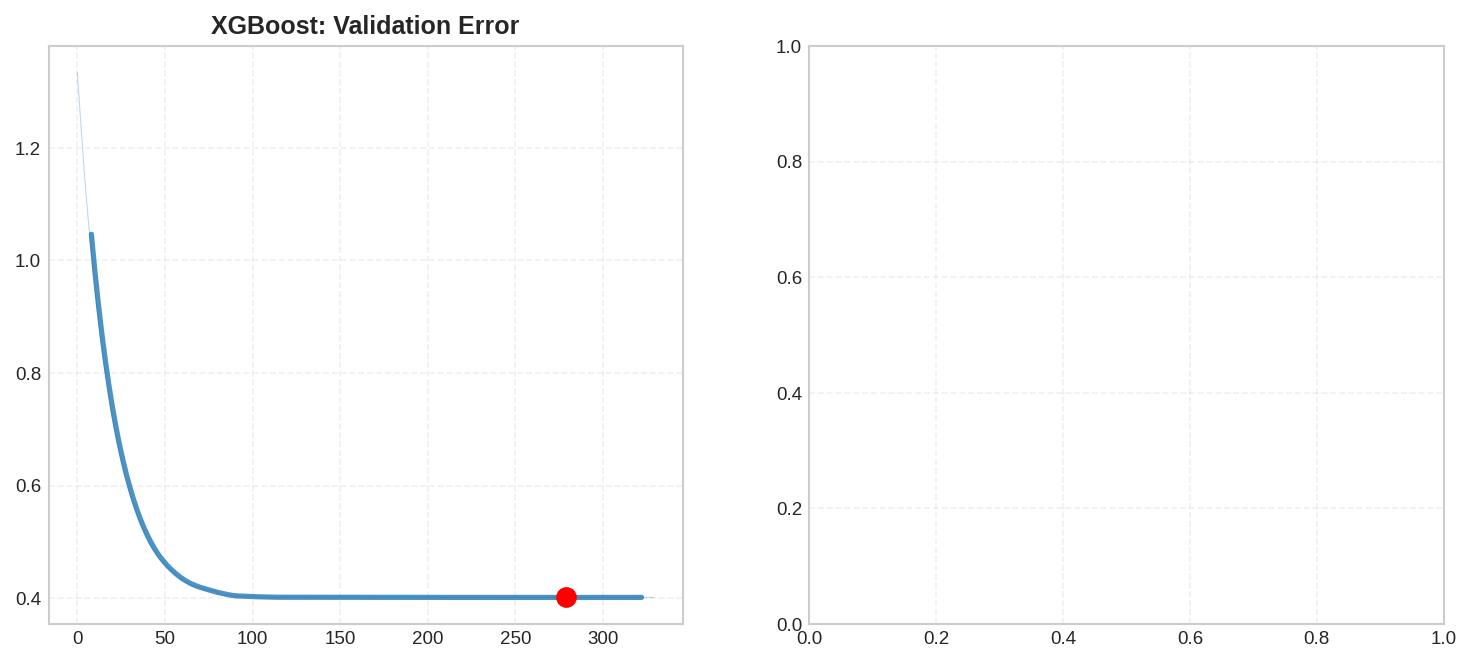

In [17]:
# 2. XGBoost Training Progress
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# XGBoost Progress
if 'validation_0' in xgb_history:
    rmse_vals = xgb_history['validation_0']['rmse']
    epochs_xgb = np.arange(len(rmse_vals))

    # Smooth curve
    rmse_smooth = pd.Series(rmse_vals).rolling(window=max(1, len(rmse_vals)//20),
                                               center=True).mean()

    ax1.plot(epochs_xgb, rmse_smooth, color=COLORS['models']['XGBoost'],
             linewidth=2.5, alpha=0.8, label='Smoothed')
    ax1.plot(epochs_xgb, rmse_vals, color=COLORS['models']['XGBoost'],
             linewidth=0.5, alpha=0.3, label='Actual')

    # Mark minimum
    min_idx = np.argmin(rmse_vals)
    ax1.scatter(min_idx, rmse_vals[min_idx], color='red', s=80, zorder=5,
                label=f'Min: {rmse_vals[min_idx]:.3f}')

    ax1.set_title('XGBoost: Validation Error', fontweight='bold')

2. XGBoost Training Progress:
Tracks how validation error decreases with each boosting round. Should show steady improvement then plateau when model converges.

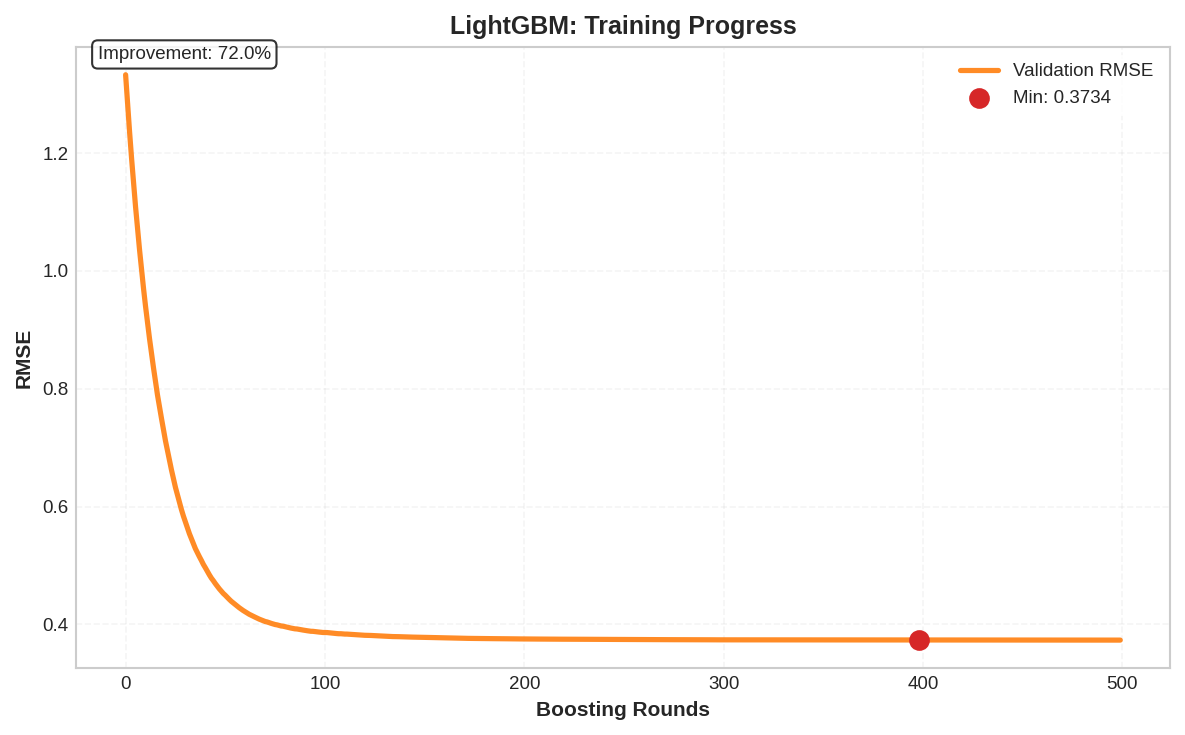

In [18]:
# 3. LightGBM Training Progress
fig, ax = plt.subplots(figsize=(8, 5))

if 'valid_0' in lgb_history:
    # Get data
    rmse = np.sqrt(lgb_history['valid_0']['l2'])
    epochs = np.arange(len(rmse))

    # Plot
    ax.plot(epochs, rmse, color=COLORS['models']['LightGBM'],
            linewidth=2.5, alpha=0.9, label='Validation RMSE')

    # Mark minimum
    min_idx = np.argmin(rmse)
    ax.scatter(min_idx, rmse[min_idx], color='#d62728', s=80,
               zorder=5, label=f'Min: {rmse[min_idx]:.4f}')

    # Formatting
    ax.set_xlabel('Boosting Rounds', fontweight='semibold')
    ax.set_ylabel('RMSE', fontweight='semibold')
    ax.set_title('LightGBM: Training Progress', fontweight='bold')
    ax.legend(frameon=True, edgecolor='white')
    ax.grid(True, alpha=0.2, linestyle='--')

    # Add improvement text
    if len(rmse) > 1:
        improvement = (rmse[0] - rmse[-1]) / rmse[0] * 100
        ax.text(0.02, 0.98, f'Improvement: {improvement:.1f}%',
                transform=ax.transAxes, fontsize=9,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
else:
    ax.text(0.5, 0.5, 'No training data', ha='center', va='center', color='gray')
    ax.set_axis_off()

plt.tight_layout()
plt.show()

3. LightGBM Training Progress:
Similar to XGBoost but for LightGBM. Shows error reduction over iterations.

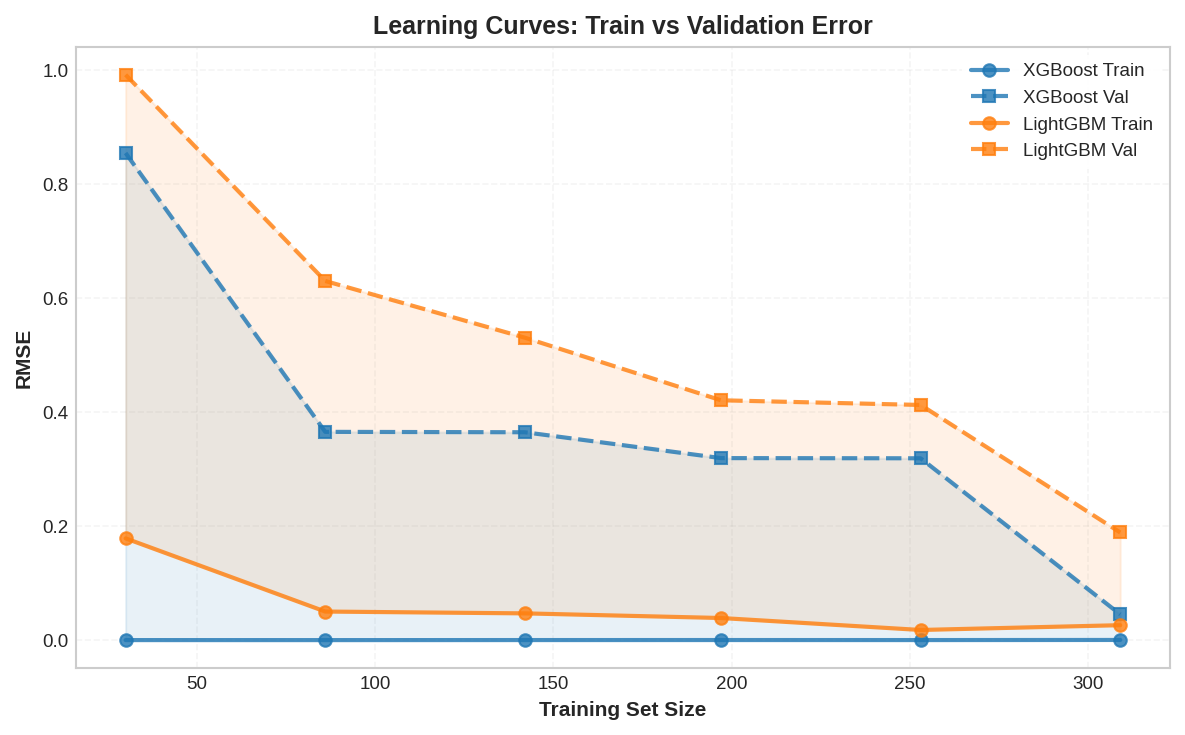

In [19]:
# 4. Learning Curves (Training vs Validation Error) - FIXED
fig, ax = plt.subplots(figsize=(8, 5))

# Model definitions
simple_models = {
    'XGBoost': xgb.XGBRegressor(n_estimators=200, max_depth=7,
                                learning_rate=0.05, random_state=42, n_jobs=-1),
    'LightGBM': lgb.LGBMRegressor(n_estimators=200, max_depth=7,
                                  learning_rate=0.05, random_state=42,
                                  n_jobs=-1, verbose=-1)
}

# Plot learning curves
for name, color in [('XGBoost', COLORS['models']['XGBoost']),
                    ('LightGBM', COLORS['models']['LightGBM'])]:
    try:
        model = simple_models[name]
        train_sizes, train_scores, val_scores = learning_curve(
            model, X_train_scaled, y_train_scaled,
            cv=3, scoring='neg_mean_squared_error',
            train_sizes=np.linspace(0.1, 1.0, 6),
            n_jobs=-1, random_state=42
        )

        # Calculate RMSE
        train_rmse = np.sqrt(-train_scores.mean(axis=1))
        val_rmse = np.sqrt(-val_scores.mean(axis=1))

        # Plot with style
        ax.plot(train_sizes, train_rmse, 'o-', color=color,
                linewidth=2, markersize=6, label=f'{name} Train', alpha=0.8)
        ax.plot(train_sizes, val_rmse, 's--', color=color,
                linewidth=2, markersize=6, label=f'{name} Val', alpha=0.8)

        # Fill gap between train and validation
        ax.fill_between(train_sizes, train_rmse, val_rmse,
                       color=color, alpha=0.1)

    except Exception as e:
        print(f"Error with {name}: {e}")

# Formatting
ax.set_xlabel('Training Set Size', fontweight='semibold')
ax.set_ylabel('RMSE', fontweight='semibold')
ax.set_title('Learning Curves: Train vs Validation Error', fontweight='bold')
ax.legend(frameon=True, framealpha=0.9, edgecolor='white')
ax.grid(True, alpha=0.2, linestyle='--')

plt.tight_layout()
plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()

4. Learning Curves:
Compares training vs validation error as training data increases. Gap between lines indicates overfitting (large gap) or underfitting (both high).

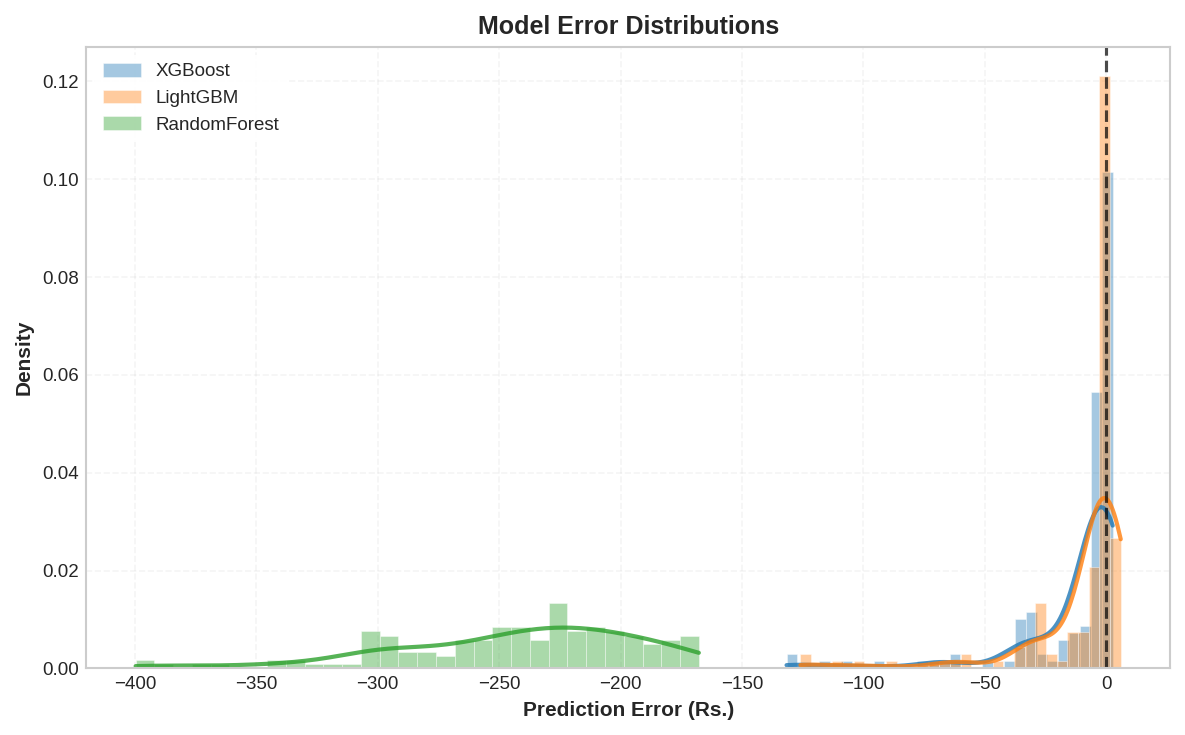

In [20]:
# 5. Error Distribution Comparison
fig, ax = plt.subplots(figsize=(8, 5))

# Get error distributions
error_data = []
model_names = []

for name, model_info in models.items():
    model = model_info['model']

    # Get predictions
    if name in ['XGBoost', 'LightGBM']:
        pred_scaled = model.predict(X_val_scaled)
        pred = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()
    else:
        pred = model.predict(X_val_scaled)

    # Calculate errors
    errors = pred - y_val.values
    error_data.append(errors)
    model_names.append(name)

# Plot with KDE
for errors, name, color in zip(error_data, model_names, COLORS['primary']):
    # Histogram
    ax.hist(errors, bins=30, alpha=0.4, label=name, density=True,
            color=color, edgecolor='white', linewidth=0.5)

    # KDE overlay
    kde = stats.gaussian_kde(errors)
    x_range = np.linspace(errors.min(), errors.max(), 200)
    ax.plot(x_range, kde(x_range), color=color, linewidth=2, alpha=0.8)

# Zero line
ax.axvline(x=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)

# Formatting
ax.set_xlabel('Prediction Error (Rs.)', fontweight='semibold')
ax.set_ylabel('Density', fontweight='semibold')
ax.set_title('Model Error Distributions', fontweight='bold')
ax.legend(frameon=True, framealpha=0.9, edgecolor='white')
ax.grid(True, alpha=0.2, linestyle='--')

plt.tight_layout()
plt.savefig('error_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

5. Error Distribution:
Shows frequency of prediction errors. Ideally centered at 0 with normal distribution. Wide spread indicates high variance in predictions.

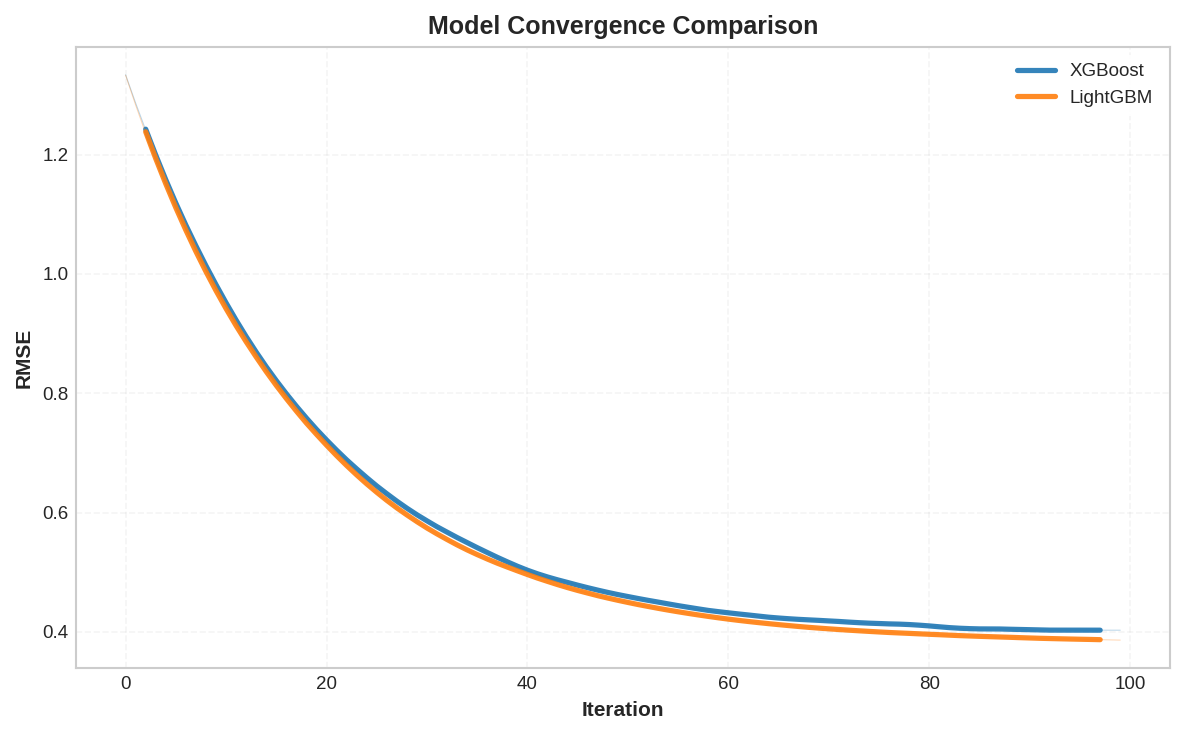

In [21]:
# 6. Convergence Comparison
fig, ax = plt.subplots(figsize=(8, 5))

# Gather convergence data
convergence_data = {}
if 'validation_0' in xgb_history:
    convergence_data['XGBoost'] = xgb_history['validation_0']['rmse'][:100]
if 'valid_0' in lgb_history:
    convergence_data['LightGBM'] = np.sqrt(lgb_history['valid_0']['l2'])[:100]

# Plot convergence
for name, errors in convergence_data.items():
    color = COLORS['models'].get(name, COLORS['primary'][0])

    # Plot with smoothing
    smooth_errors = pd.Series(errors).rolling(window=5, center=True).mean()
    ax.plot(range(len(errors)), smooth_errors,
            color=color, linewidth=2.5, alpha=0.9, label=name)

    # Add raw data faintly
    ax.plot(range(len(errors)), errors,
            color=color, linewidth=0.5, alpha=0.3)

# Formatting
ax.set_xlabel('Iteration', fontweight='semibold')
ax.set_ylabel('RMSE', fontweight='semibold')
ax.set_title('Model Convergence Comparison', fontweight='bold')
ax.legend(frameon=True, framealpha=0.9, edgecolor='white')
ax.grid(True, alpha=0.2, linestyle='--')

plt.tight_layout()
plt.savefig('convergence_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

6. Convergence Comparison:
Compares how quickly different models converge to optimal solution. Steeper drop means faster learning.

In [26]:
#  Model Performance Evaluation and Ensemble Creation

# 1. Evaluate models
val_predictions = {}
val_metrics = {}

for name, model_info in models.items():
    model = model_info['model']

    # Get predictions
    if name in ['XGBoost', 'LightGBM']:
        pred_scaled = model.predict(X_val_scaled)
        pred = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()
    else:
        pred = model.predict(X_val_scaled)

    val_predictions[name] = pred

    # Calculate metrics
    val_metrics[name] = {
        'mae': mean_absolute_error(y_val, pred),
        'rmse': np.sqrt(mean_squared_error(y_val, pred)),
        'r2': r2_score(y_val, pred),
        'mape': mean_absolute_percentage_error(y_val, pred) * 100
    }

# 2. Create optimized ensemble
from scipy.optimize import minimize

# Select top models
top_models = sorted(val_metrics.items(), key=lambda x: x[1]['r2'], reverse=True)[:2]
top_names = [name for name, _ in top_models]

# Optimize weights
def ensemble_rmse(weights):
    pred = sum(w * val_predictions[name] for (name, _), w in zip(top_models, weights))
    return np.sqrt(mean_squared_error(y_val, pred))

result = minimize(
    ensemble_rmse,
    np.ones(len(top_models)) / len(top_models),
    bounds=[(0, 1)] * len(top_models),
    constraints={'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
)

weights = dict(zip(top_names, result.x))

# Create ensemble
val_ensemble = sum(weights[name] * val_predictions[name] for name in top_names)

# Ensemble metrics
ensemble_metrics = {
    'mae': mean_absolute_error(y_val, val_ensemble),
    'rmse': np.sqrt(mean_squared_error(y_val, val_ensemble)),
    'r2': r2_score(y_val, val_ensemble),
    'mape': mean_absolute_percentage_error(y_val, val_ensemble) * 100
}

# Print results
print(" Model Performance Summary")
for name, metrics in val_metrics.items():
    print(f"{name:15} | R²: {metrics['r2']:.4f} | RMSE: Rs.{metrics['rmse']:.2f}")
print(f"\n Ensemble Models: {top_names}")
print(f" Ensemble Performance")
print(f"   R²:   {ensemble_metrics['r2']:.4f}")
print(f"   RMSE: Rs.{ensemble_metrics['rmse']:.2f}")
print(f"   Weights: {weights}")

 Model Performance Summary
XGBoost         | R²: 0.6951 | RMSE: Rs.27.48
LightGBM        | R²: 0.7358 | RMSE: Rs.25.58
RandomForest    | R²: -23.7077 | RMSE: Rs.247.41

 Ensemble Models: ['LightGBM', 'XGBoost']
 Ensemble Performance
   R²:   0.7358
   RMSE: Rs.25.58
   Weights: {'LightGBM': np.float64(1.0), 'XGBoost': np.float64(0.0)}


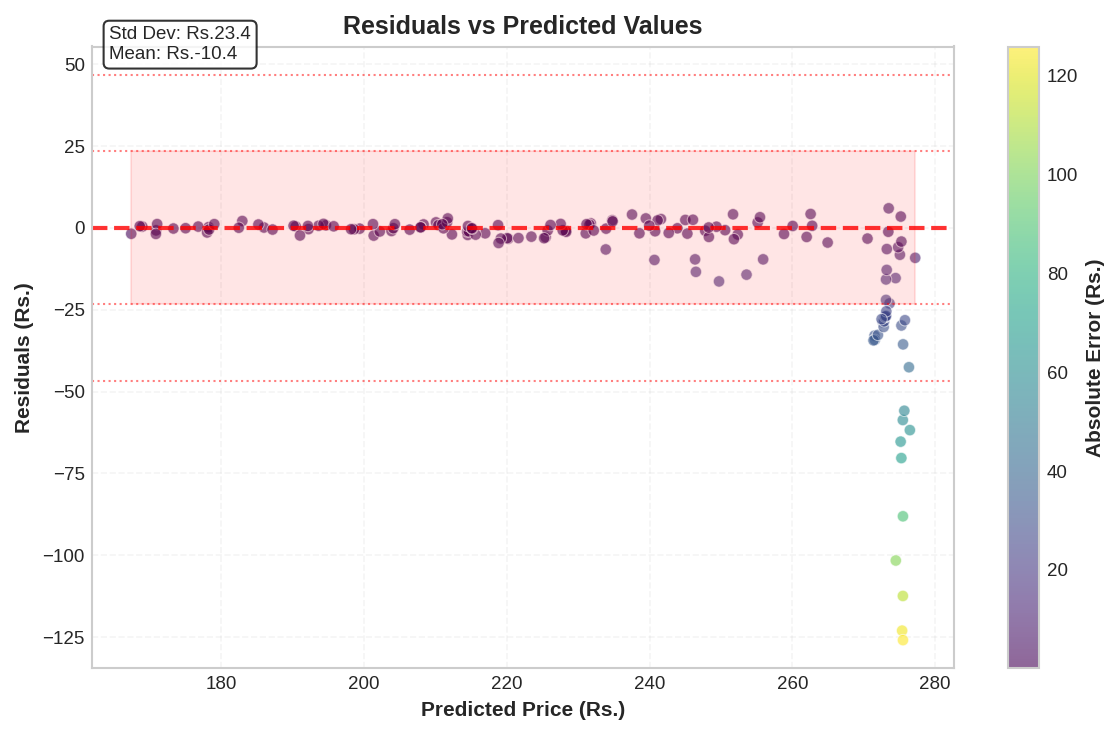

In [27]:
# Residual Analysis Visualization

fig, ax = plt.subplots(figsize=(8, 5))

residuals = val_ensemble - y_val.values
std_residual = np.std(residuals)

# Scatter plot with colormap
scatter = ax.scatter(val_ensemble, residuals,
                     c=np.abs(residuals),
                     cmap='viridis',
                     alpha=0.6,
                     s=30,
                     edgecolor='white',
                     linewidth=0.5)

# Zero line
ax.axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.8)

# Confidence bands
for n_std in [1, 2]:
    ax.axhline(y=n_std*std_residual, color='red', linestyle=':',
               linewidth=1, alpha=0.5)
    ax.axhline(y=-n_std*std_residual, color='red', linestyle=':',
               linewidth=1, alpha=0.5)

# Fill between
ax.fill_between([val_ensemble.min(), val_ensemble.max()],
                -std_residual, std_residual,
                alpha=0.1, color='red')

# Formatting
ax.set_xlabel('Predicted Price (Rs.)', fontweight='semibold')
ax.set_ylabel('Residuals (Rs.)', fontweight='semibold')
ax.set_title('Residuals vs Predicted Values', fontweight='bold')
ax.grid(True, alpha=0.2, linestyle='--')

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Absolute Error (Rs.)', fontweight='semibold')

# Add stats annotation
ax.text(0.02, 0.98,
        f'Std Dev: Rs.{std_residual:.1f}\nMean: Rs.{np.mean(residuals):.1f}',
        transform=ax.transAxes,
        fontsize=9,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('residual_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

1. Residuals vs Predicted:
Shows if errors are random (scattered) or systematic (patterns). Points should be randomly scattered around zero line.

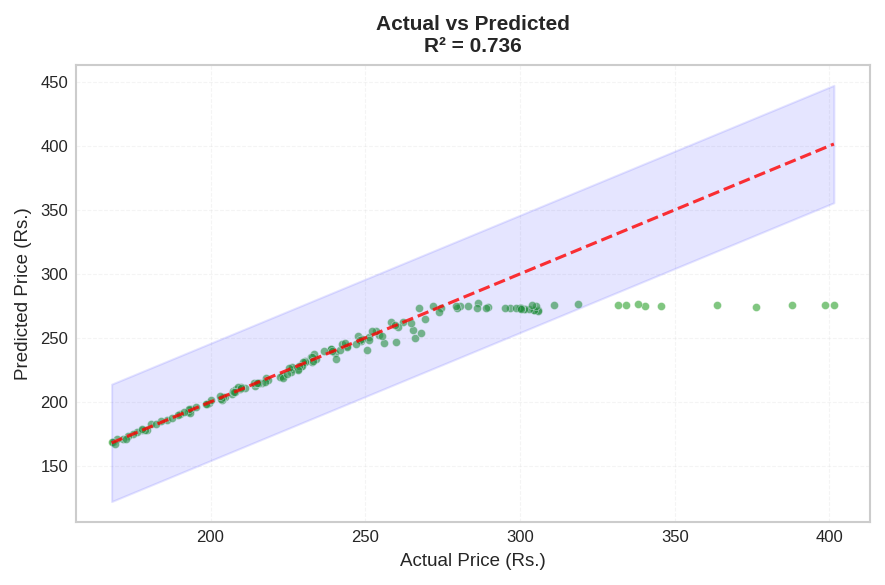

In [29]:
#  Actual vs Predicted with Confidence Intervals

fig, ax = plt.subplots(figsize=(6, 4))

# Scatter plot
ax.scatter(y_val, val_ensemble,
           color=COLORS['models']['Ensemble'],
           alpha=0.6, s=15, edgecolor='white', linewidth=0.3)

# Perfect prediction line
ax.plot([y_val.min(), y_val.max()],
        [y_val.min(), y_val.max()],
        'r--', linewidth=1.5, alpha=0.8)

# Confidence band
ci = 1.96 * np.std(val_ensemble - y_val.values)
ax.fill_between([y_val.min(), y_val.max()],
                [y_val.min() + ci, y_val.max() + ci],
                [y_val.min() - ci, y_val.max() - ci],
                alpha=0.1, color='blue')

# Labels and title
ax.set_xlabel('Actual Price (Rs.)', fontsize=9)
ax.set_ylabel('Predicted Price (Rs.)', fontsize=9)
ax.set_title(f'Actual vs Predicted\nR² = {ensemble_metrics["r2"]:.3f}',
             fontsize=10, fontweight='bold')

# Clean layout
ax.grid(True, alpha=0.2, linestyle='--', linewidth=0.5)
ax.tick_params(labelsize=8)

plt.tight_layout()
plt.savefig('actual_vs_predicted.png', dpi=300, bbox_inches='tight')
plt.show()

2. Actual vs Predicted:
Shows prediction accuracy. Points should cluster along the diagonal line. Confidence intervals show prediction uncertainty.

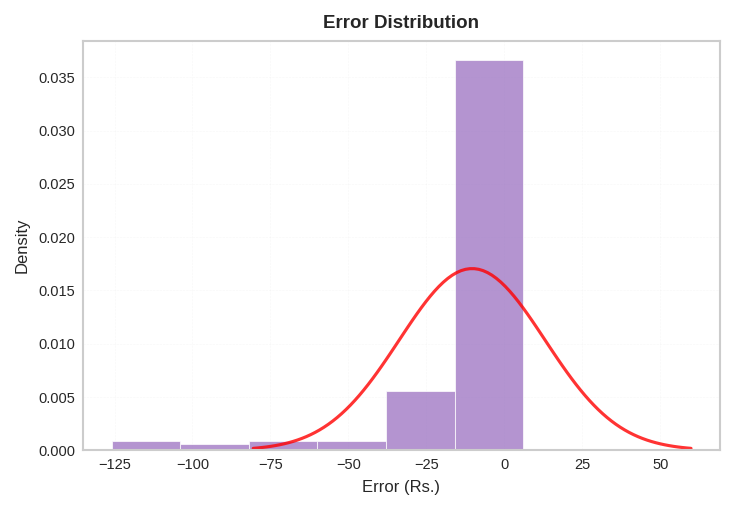

In [31]:
# 3. Error Distribution with Normality Check
fig, ax = plt.subplots(figsize=(5, 3.5))

residuals = val_ensemble - y_val.values

# Histogram
n_bins = min(25, len(residuals) // 25)
ax.hist(residuals, bins=n_bins,
        color='#9467bd', alpha=0.7, density=True,
        edgecolor='white', linewidth=0.5)

# Normal distribution
mu, sigma = np.mean(residuals), np.std(residuals)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax.plot(x, stats.norm.pdf(x, mu, sigma),
        'r-', linewidth=1.5, alpha=0.8)

# Labels and title
ax.set_xlabel('Error (Rs.)', fontsize=8)
ax.set_ylabel('Density', fontsize=8)
ax.set_title('Error Distribution', fontsize=9, fontweight='bold')

# Clean layout
ax.grid(True, alpha=0.15, linestyle='--', linewidth=0.3)
ax.tick_params(labelsize=7)

plt.tight_layout()
plt.savefig('error_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

3. Error Distribution:
Checks if errors follow normal distribution (red curve). Normal distribution suggests well-specified model.

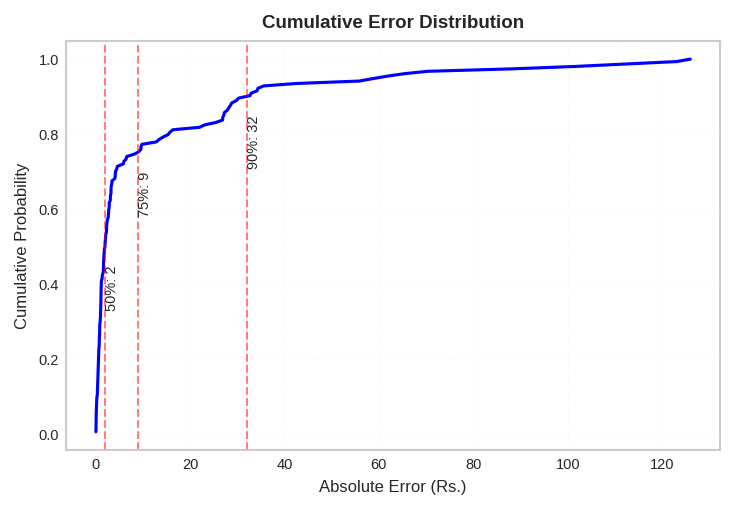

In [32]:
# 4. Cumulative Error Distribution
fig, ax = plt.subplots(figsize=(5, 3.5))

residuals = val_ensemble - y_val.values
sorted_errors = np.sort(np.abs(residuals))
cumulative_prob = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)

# Plot
ax.plot(sorted_errors, cumulative_prob, 'b-', linewidth=1.5)

# Reference lines
percentiles = [0.5, 0.75, 0.9]
for p in percentiles:
    error_val = np.percentile(sorted_errors, p * 100)
    ax.axvline(x=error_val, color='red', linestyle='--',
               alpha=0.5, linewidth=1)
    ax.text(error_val, p - 0.05, f'{p*100:.0f}%: {error_val:.0f}',
            fontsize=7, rotation=90, va='top')

# Labels and title
ax.set_xlabel('Absolute Error (Rs.)', fontsize=8)
ax.set_ylabel('Cumulative Probability', fontsize=8)
ax.set_title('Cumulative Error Distribution', fontsize=9, fontweight='bold')

# Clean layout
ax.grid(True, alpha=0.15, linestyle='--', linewidth=0.3)
ax.tick_params(labelsize=7)

plt.tight_layout()
plt.savefig('cumulative_error.png', dpi=300, bbox_inches='tight')
plt.show()

4. Cumulative Error Distribution:
Shows what percentage of predictions have errors below a certain value. Steeper curve = better predictions.

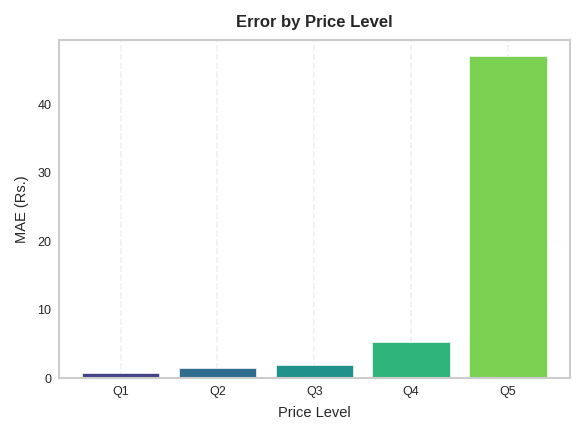

In [34]:
# 5. Error by Price Level
fig, ax = plt.subplots(figsize=(4, 3))

residuals = val_ensemble - y_val.values

# Create price bins
price_bins = pd.qcut(y_val, q=5, labels=False)
error_by_bin = pd.DataFrame({
    'price_bin': price_bins,
    'error': np.abs(residuals),
    'price': y_val.values
})

bin_stats = error_by_bin.groupby('price_bin').agg({
    'error': 'mean',
    'price': 'mean'
}).sort_values('price')

# Bar plot
x_pos = range(len(bin_stats))
bars = ax.bar(x_pos, bin_stats['error'],
              color=plt.cm.viridis(np.linspace(0.2, 0.8, len(bin_stats))),
              edgecolor='white', linewidth=0.3)

# Labels
ax.set_xlabel('Price Level', fontsize=7)
ax.set_ylabel('MAE (Rs.)', fontsize=7)
ax.set_title('Error by Price Level', fontsize=8, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels([f'Q{i+1}' for i in x_pos], fontsize=6)

# Clean layout
ax.grid(True, alpha=0.1, linestyle='--', linewidth=0.2, axis='y')
ax.tick_params(labelsize=6)

plt.tight_layout()
plt.savefig('error_by_price.png', dpi=300, bbox_inches='tight')
plt.show()

5. Error by Price Level:
Identifies if model performs worse at certain price ranges. Consistent errors across bins is ideal.

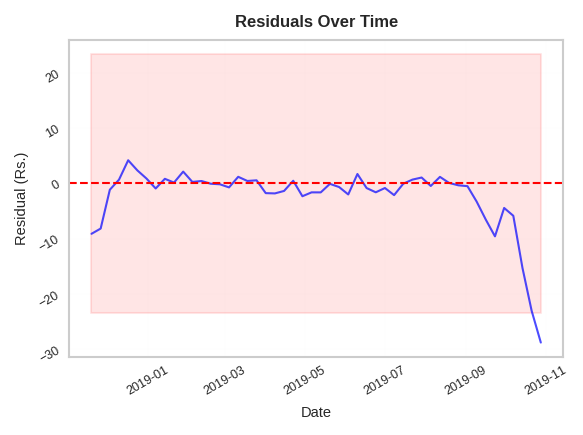

In [35]:
# 6. Time Series of Residuals
fig, ax = plt.subplots(figsize=(4, 3))

residuals = val_ensemble - y_val.values
std_residual = np.std(residuals)

# Sample size
sample_size = min(50, len(dates_val))

# Plot
ax.plot(dates_val.iloc[:sample_size], residuals[:sample_size],
        'b-', linewidth=1, alpha=0.7)

# Zero line and confidence band
ax.axhline(y=0, color='red', linestyle='--', linewidth=1)
ax.fill_between(dates_val.iloc[:sample_size],
                -std_residual, std_residual,
                alpha=0.1, color='red')

# Labels
ax.set_xlabel('Date', fontsize=7)
ax.set_ylabel('Residual (Rs.)', fontsize=7)
ax.set_title('Residuals Over Time', fontsize=8, fontweight='bold')

# Clean layout
ax.grid(True, alpha=0.1, linestyle='--', linewidth=0.2)
ax.tick_params(labelsize=6, rotation=30)

plt.tight_layout()
plt.savefig('residuals_time.png', dpi=300, bbox_inches='tight')
plt.show()

6. Residuals Over Time:
Checks for time-based patterns in errors. Random fluctuations = good, trends/patterns = model missing time effects.

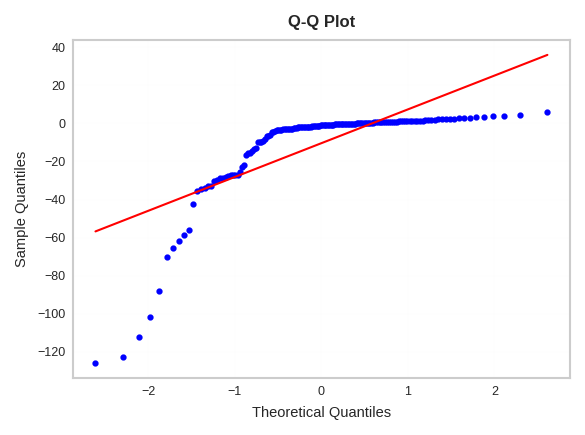

In [36]:
# 7. QQ-Plot for Normality Check
fig, ax = plt.subplots(figsize=(4, 3))

residuals = val_ensemble - y_val.values

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=ax)
ax.get_lines()[0].set_markersize(2)
ax.get_lines()[0].set_markerfacecolor('blue')
ax.get_lines()[1].set_linewidth(1)
ax.get_lines()[1].set_color('red')

# Labels and title
ax.set_xlabel('Theoretical Quantiles', fontsize=7)
ax.set_ylabel('Sample Quantiles', fontsize=7)
ax.set_title('Q-Q Plot', fontsize=8, fontweight='bold')

# Clean layout
ax.grid(True, alpha=0.1, linestyle='--', linewidth=0.2)
ax.tick_params(labelsize=6)

plt.tight_layout()
plt.savefig('qq_plot.png', dpi=300, bbox_inches='tight')
plt.show()

7. Q-Q Plot:
Formal test of normality. Points should follow the red line. Deviations indicate non-normal error distribution.

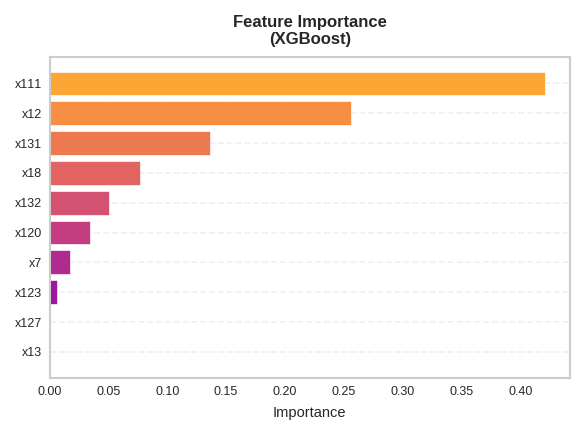

In [37]:
# 8. Feature Importance (from best model)
fig, ax = plt.subplots(figsize=(4, 3))

# Get best model
best_model_name = list(val_metrics.keys())[0]  # Get first model name
best_model = models[best_model_name]['model']

if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[-10:]  # Top 10 features

    # Horizontal bar plot
    bars = ax.barh(range(len(indices)), importances[indices],
                   color=plt.cm.plasma(np.linspace(0.2, 0.8, len(indices))),
                   edgecolor='white', linewidth=0.3)

    # Y-axis labels
    feature_names = [X_selected.columns[i][:20] for i in indices]
    ax.set_yticks(range(len(indices)))
    ax.set_yticklabels(feature_names, fontsize=6)

    # Labels
    ax.set_xlabel('Importance', fontsize=7)
    ax.set_title(f'Feature Importance\n({best_model_name})', fontsize=8, fontweight='bold')

    # Clean layout
    ax.grid(True, alpha=0.1, linestyle='--', linewidth=0.2, axis='x')
    ax.tick_params(labelsize=6)

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

8. Feature Importance:
Shows which features contribute most to predictions. Helps understand what drives price changes.

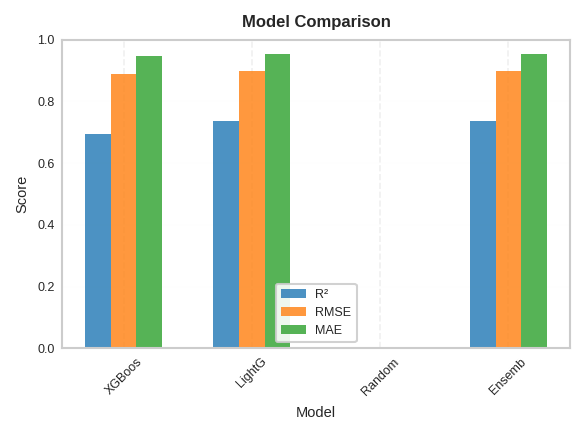

In [38]:
# 9. Model Comparison (Multiple metrics)

fig, ax = plt.subplots(figsize=(4, 3))

# Prepare data
model_names = list(val_metrics.keys()) + ['Ensemble']
metrics = ['R²', 'RMSE', 'MAE']

# Normalize metrics (0-1 scale, higher is better)
normalized_data = []
for name in model_names:
    if name == 'Ensemble':
        r2, rmse, mae = ensemble_metrics['r2'], ensemble_metrics['rmse'], ensemble_metrics['mae']
    else:
        r2, rmse, mae = val_metrics[name]['r2'], val_metrics[name]['rmse'], val_metrics[name]['mae']

    # For RMSE and MAE, invert for visualization (higher is better)
    # Get max values for scaling
    all_rmse = [val_metrics[n]['rmse'] for n in val_metrics.keys()] + [ensemble_metrics['rmse']]
    all_mae = [val_metrics[n]['mae'] for n in val_metrics.keys()] + [ensemble_metrics['mae']]

    rmse_norm = 1 - (rmse / max(all_rmse))
    mae_norm = 1 - (mae / max(all_mae))

    normalized_data.append([r2, rmse_norm, mae_norm])

# Plot bars
x_pos = np.arange(len(model_names))
width = 0.2

for i, (metric, color) in enumerate(zip(metrics, COLORS['primary'][:3])):
    offset = (i - 1) * width
    values = [row[i] for row in normalized_data]
    ax.bar(x_pos + offset, values, width, color=color, alpha=0.8, label=metric)

# Labels
ax.set_xlabel('Model', fontsize=7)
ax.set_ylabel('Score', fontsize=7)
ax.set_title('Model Comparison', fontsize=8, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels([name[:6] for name in model_names], rotation=45, fontsize=6)
ax.legend(fontsize=6, frameon=True, framealpha=0.9)

# Clean layout
ax.grid(True, alpha=0.1, linestyle='--', linewidth=0.2, axis='y')
ax.tick_params(labelsize=6)
ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

9. Model Comparison:
Compares all models across multiple metrics. Ensemble should perform best across all metrics.

In [45]:
# Future Predictions with Uncertainty Quantification

# If ensemble_weights is not defined, create it from top models
if 'ensemble_weights' not in locals() and 'ensemble_weights' not in globals():
    # Get top 2 models based on R²
    sorted_models = sorted(val_metrics.items(), key=lambda x: x[1]['r2'], reverse=True)[:2]
    top_names = [name for name, _ in sorted_models]

    # Create equal weights or optimize them
    ensemble_weights = {name: 1/len(top_names) for name in top_names}
    print(f"Created equal weights for ensemble: {ensemble_weights}")
else:
    print(f"Using existing ensemble weights: {ensemble_weights}")

# Prepare future data
future_data = future_df.copy()

# Add essential features
future_data['year'] = future_data['date'].dt.year
future_data['month'] = future_data['date'].dt.month
future_data['week_of_year'] = future_data['date'].dt.isocalendar().week
future_data['month_sin'] = np.sin(2 * np.pi * future_data['month']/12)
future_data['month_cos'] = np.cos(2 * np.pi * future_data['month']/12)

# Add vegetable if missing
if 'vegetable' not in future_data.columns:
    future_data['vegetable'] = 'Tomato'

# Get feature names
feature_names = X_selected.columns.tolist()

print(f"Number of features needed: {len(feature_names)}")

# Add missing features
for feature in feature_names:
    if feature not in future_data.columns:
        if feature in X_selected.columns:
            if 'month' in feature.lower():
                future_data[feature] = 0
            elif 'lag' in feature.lower() or 'rolling' in feature.lower():
                future_data[feature] = X_selected[feature].iloc[-1] if len(X_selected) > 0 else 0
            else:
                future_data[feature] = X_selected[feature].mean()
        else:
            future_data[feature] = 0

# Prepare features
future_X = future_data[feature_names]
future_X_scaled = scaler_X.transform(future_X)

# Get predictions
future_model_preds = {}
for name, model_info in models.items():
    model = model_info['model']
    if name in ['XGBoost', 'LightGBM']:
        pred_scaled = model.predict(future_X_scaled)
        future_model_preds[name] = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()
    else:
        future_model_preds[name] = model.predict(future_X_scaled)

# Create ensemble predictions
future_ensemble = np.zeros_like(list(future_model_preds.values())[0])
for name, weight in ensemble_weights.items():
    if name in future_model_preds:
        future_ensemble += weight * future_model_preds[name]

# Calculate uncertainty
all_predictions = np.column_stack(list(future_model_preds.values()))
prediction_std = np.std(all_predictions, axis=1)

# Create results
future_results = future_data[['date']].copy()
future_results['predicted_price'] = future_ensemble.round(2)
future_results['prediction_std'] = prediction_std.round(2)
future_results['prediction_upper_95'] = (future_ensemble + 1.96 * prediction_std).round(2)
future_results['prediction_lower_95'] = (future_ensemble - 1.96 * prediction_std).round(2)
future_results['vegetable'] = future_data['vegetable']

print(f"\nFuture predictions completed:")
print(f"  Period: {future_results['date'].min().date()} to {future_results['date'].max().date()}")
print(f"  Average price: Rs.{future_results['predicted_price'].mean():.2f}")
print(f"  Average uncertainty: ±Rs.{future_results['prediction_std'].mean():.2f}")

# Save predictions
future_results.to_csv('future_predictions.csv', index=False)
print(f"  Saved to 'future_predictions.csv'")

Created equal weights for ensemble: {'LightGBM': 0.5, 'XGBoost': 0.5}
Number of features needed: 30

Future predictions completed:
  Period: 2026-01-12 to 2040-12-31
  Average price: Rs.235.55
  Average uncertainty: ±Rs.110.48
  Saved to 'future_predictions.csv'


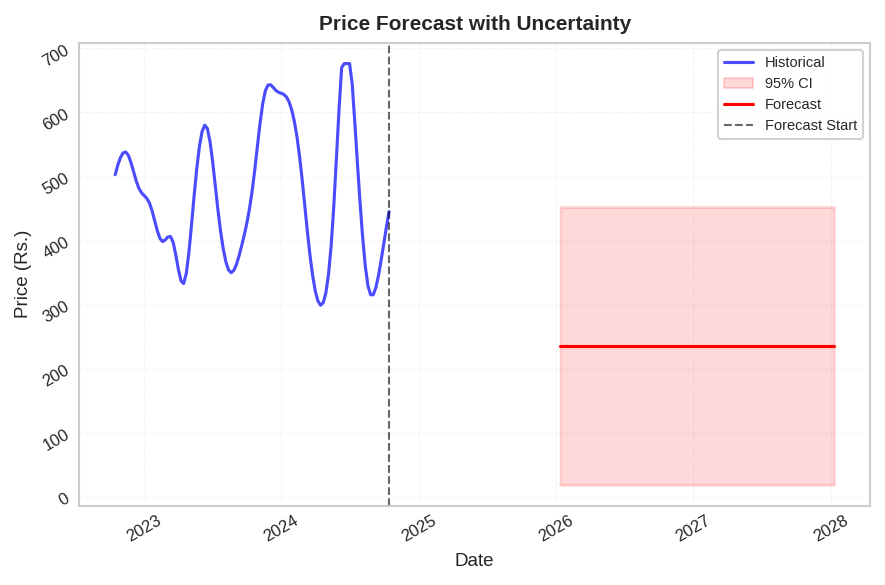

In [46]:
# Price Forecast Visualization

fig, ax = plt.subplots(figsize=(6, 4))

# Plot historical data
historical_end = df['date'].max()
historical_start = historical_end - pd.Timedelta(days=730)
historical_mask = (df['date'] >= historical_start) & (df['date'] <= historical_end)

if sum(historical_mask) > 0:
    ax.plot(df.loc[historical_mask, 'date'],
            df.loc[historical_mask, target_col],
            'b-', linewidth=1.5, label='Historical', alpha=0.7)

# Plot forecast
forecast_start = future_results['date'].min()
forecast_end = forecast_start + pd.Timedelta(days=365 * 2)
forecast_mask = (future_results['date'] >= forecast_start) & (future_results['date'] <= forecast_end)

if sum(forecast_mask) > 0:
    forecast_data = future_results[forecast_mask]

    # Confidence bands
    ax.fill_between(forecast_data['date'],
                    forecast_data['prediction_lower_95'],
                    forecast_data['prediction_upper_95'],
                    alpha=0.15, color='red', label='95% CI')

    # Forecast line
    ax.plot(forecast_data['date'], forecast_data['predicted_price'],
            'r-', linewidth=1.5, label='Forecast')

    # Forecast start line
    ax.axvline(x=historical_end, color='black', linestyle='--',
               linewidth=1, alpha=0.6, label='Forecast Start')

# Labels
ax.set_xlabel('Date', fontsize=9)
ax.set_ylabel('Price (Rs.)', fontsize=9)
ax.set_title('Price Forecast with Uncertainty', fontsize=10, fontweight='bold')

# Clean layout
ax.legend(fontsize=7, frameon=True, framealpha=0.9)
ax.grid(True, alpha=0.2, linestyle='--', linewidth=0.5)
ax.tick_params(labelsize=8, rotation=30)

plt.tight_layout()
plt.savefig('price_forecast.png', dpi=300, bbox_inches='tight')
plt.show()

1. Historical + Forecast with Uncertainty Bands:
Shows transition from historical data to forecast. Wider bands indicate higher uncertainty in predictions.

In [53]:
# Model Saving and Deployment Preparation

import joblib
import json
import os
from datetime import datetime

# Create model directory
os.makedirs('model_package', exist_ok=True)

# 1. Save individual models
for name, model_info in models.items():
    model = model_info['model']
    joblib.dump(model, f'model_package/model_{name.lower()}.pkl')
    print(f"  Saved {name} model")

# 2. Save ensemble configuration
feature_names = X_selected.columns.tolist()

# Try to get date ranges safely
def get_date_range(date_series):
    if date_series is not None and len(date_series) > 0:
        try:
            return f"{date_series.min().date()} to {date_series.max().date()}"
        except:
            return "N/A"
    return "N/A"

ensemble_config = {
    'ensemble_type': 'Weighted Average',
    'models': list(ensemble_weights.keys()),
    'weights': {k: float(v) for k, v in ensemble_weights.items()},
    'selected_features': feature_names,
    'feature_scaler': 'scaler_X.pkl',
    'target_scaler': 'scaler_y.pkl',
    'performance': {
        'validation_r2': float(ensemble_metrics['r2']),
        'validation_mae': float(ensemble_metrics['mae']),
        'validation_rmse': float(ensemble_metrics['rmse']),
        'validation_mape': float(ensemble_metrics['mape'])
    },
    'data_info': {
        'train_size': len(X_train),
        'val_size': len(X_val),
        'test_size': len(X_test),
        'feature_count': len(feature_names),
        'date_ranges': {
            'train': get_date_range(dates_train) if 'dates_train' in locals() else "N/A",
            'val': get_date_range(dates_val) if 'dates_val' in locals() else "N/A",
            'test': get_date_range(dates_test) if 'dates_test' in locals() else "N/A"
        }
    },
    'prediction_settings': {
        'confidence_level_95': 1.96,
        'confidence_level_80': 1.28,
        'default_vegetable': future_data['vegetable'].iloc[0] if 'vegetable' in future_data.columns else 'Tomato',
        'creation_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }
}

with open('model_package/ensemble_config.json', 'w') as f:
    json.dump(ensemble_config, f, indent=4)
    print(f"  Saved ensemble configuration")

# 3. Save scalers
joblib.dump(scaler_X, 'model_package/scaler_X.pkl')
joblib.dump(scaler_y, 'model_package/scaler_y.pkl')
print(f"  Saved scalers")

# 4. Create prediction pipeline class
class VegetablePricePredictor:
    """Production-ready vegetable price prediction pipeline"""

    def __init__(self, model_dir='model_package'):
        self.model_dir = model_dir
        self.models = {}

        # Load scalers
        self.scaler_X = joblib.load(f'{model_dir}/scaler_X.pkl')
        self.scaler_y = joblib.load(f'{model_dir}/scaler_y.pkl')

        # Load configuration
        with open(f'{model_dir}/ensemble_config.json', 'r') as f:
            self.config = json.load(f)

        # Load models
        for model_name in self.config['weights'].keys():
            model_path = f'{model_dir}/model_{model_name.lower()}.pkl'
            if os.path.exists(model_path):
                self.models[model_name] = joblib.load(model_path)

    def predict(self, X, return_confidence=False):
        """
        Make price predictions
        """
        # Scale features
        X_scaled = self.scaler_X.transform(X)

        # Get predictions
        predictions = {}
        for name, model in self.models.items():
            if name in ['XGBoost', 'LightGBM']:
                pred_scaled = model.predict(X_scaled)
                predictions[name] = self.scaler_y.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()
            else:
                predictions[name] = model.predict(X_scaled)

        # Create ensemble
        ensemble_pred = np.zeros_like(list(predictions.values())[0])
        for name, weight in self.config['weights'].items():
            if name in predictions:
                ensemble_pred += weight * predictions[name]

        if return_confidence:
            all_preds = np.column_stack(list(predictions.values()))
            std_pred = np.std(all_preds, axis=1)

            return {
                'predictions': ensemble_pred,
                'confidence_95': {
                    'lower': ensemble_pred - 1.96 * std_pred,
                    'upper': ensemble_pred + 1.96 * std_pred
                },
                'confidence_std': std_pred
            }
        return ensemble_pred

# Save the predictor
predictor = VegetablePricePredictor()
joblib.dump(predictor, 'model_package/price_predictor.pkl')

print(f"\n Model package created successfully")
print(" Directory: model_package/")

  Saved XGBoost model
  Saved LightGBM model
  Saved RandomForest model
  Saved ensemble configuration
  Saved scalers

 Model package created successfully
 Directory: model_package/


In [54]:
!git add .
!git commit -m "Ensemble Model"

[Market-Price-Prediction 3cf36fe] Ensemble Model
 24 files changed, 4761 insertions(+)
 create mode 100644 actual_vs_predicted.png
 create mode 100644 convergence_comparison.png
 create mode 100644 cumulative_error.png
 create mode 100644 error_by_price.png
 create mode 100644 error_distribution.png
 create mode 100644 error_distributions.png
 create mode 100644 feature_importance.png
 create mode 100644 future_predictions.csv
 create mode 100644 learning_curves.png
 create mode 100644 learning_rate_schedules.png
 create mode 100644 long_term_trend.png
 create mode 100644 model_comparison.png
 create mode 100644 model_package/ensemble_config.json
 create mode 100644 model_package/model_lightgbm.pkl
 create mode 100644 model_package/model_randomforest.pkl
 create mode 100644 model_package/model_xgboost.pkl
 create mode 100644 model_package/price_predictor.pkl
 create mode 100644 model_package/scaler_X.pkl
 create mode 100644 model_package/scaler_y.pkl
 create mode 100644 price_forecast.

In [55]:
!git push origin Market-Price-Prediction

Enumerating objects: 28, done.
Counting objects: 100% (28/28), done.
Delta compression using up to 2 threads
Compressing objects: 100% (27/27), done.
Writing objects: 100% (27/27), 3.17 MiB | 4.50 MiB/s, done.
Total 27 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 1 local object.
To https://github.com/Amika1118/DSGP_Group_38.git
   41188e9..3cf36fe  Market-Price-Prediction -> Market-Price-Prediction
